### Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import gensim
from gensim.models import Word2Vec

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

import fun_encoding as fe
import fun_metrics as fm
import fun_features_engineering 

In [ ]:
# Constantes

URL_PREFIXE : str = 'https://raw.githubusercontent.com/Franck-Dernoncourt/pubmed-rct/master/PubMed_20k_RCT/'
URL_TRAIN : str = URL_PREFIXE + 'train.txt'
URL_TEST : str = URL_PREFIXE + 'test.txt'

In [2]:

df_train = fe.create_df_clean(URL_TRAIN)
df_test = fe.create_df_clean(URL_TEST)

# df_train = pd.read_csv('./df_train_20k.csv')
# df_test = pd.read_csv('./df_test_20k.csv')

In [5]:
df_train.shape, df_test.shape

((180040, 20), (30135, 20))

## Model 1

Fonction de génération de modèle de word embedding

Création de notre modèle

In [ ]:
model = fe.create_word_embeddings(df_train['sentence'].tolist())

### Test hyperparameters

We just keep the hyperparameters window

In [10]:
window_l : list[int] = [3, 5, 7, 10, 15]

for window in window_l :
    model : gensim.models.word2vec.Word2Vec = fe.create_word_embeddings(df_train['sentence'].tolist(), window = window)
    model.save(f'./models/model_w2v_{window}.bin')
    print(f"Model with {window} window saved")

Model with 3 vector_size saved
Model with 5 vector_size saved
Model with 7 vector_size saved
Model with 10 vector_size saved
Model with 15 vector_size saved


In [6]:
import fun_features_engineering

window_l : list[int] = [3, 5, 7, 10, 15]

linear_training_score_window : list = []
linear_valid_score_window : list = []

for window in window_l :
    model = Word2Vec.load(f'./models/model_w2v_{window}.bin')
    X_train, y_train, X_test, y_test = fun_features_engineering.get_final_data(df_train, df_test, model)

    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)
    print(X_train.shape)
    print(f"Model with {window} window done")

    linear_training_score_window.append(clf.score(X_train, y_train))
    linear_valid_score_window.append(clf.score(X_test, y_test))

KeyboardInterrupt: 

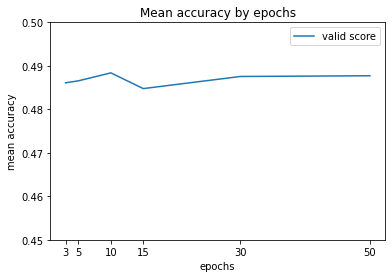

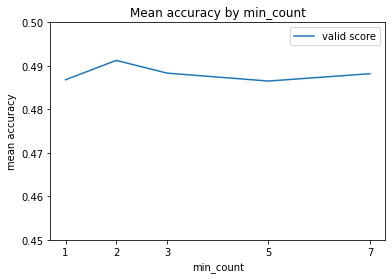

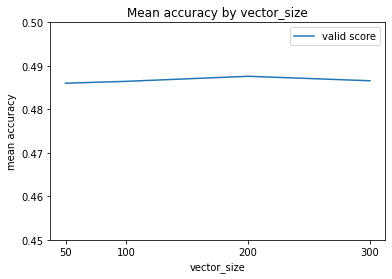

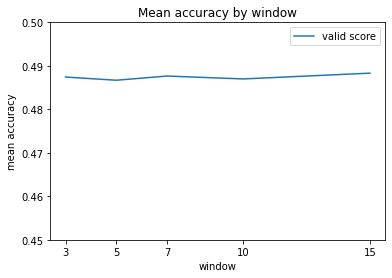

In [15]:
def plot_mean_accuracy_by_epochs(label : str, list : list[int], linear_valid_score : list[float]) :
    plt.plot(list, linear_valid_score , label= "valid score")
    plt.xlabel(label)
    plt.ylabel("mean accuracy")
    plt.xticks(list)
    plt.legend()
    plt.ylim([0.45,0.5])
    plt.title(f"Mean accuracy by {label}")
    plt.show()

plot_mean_accuracy_by_epochs("window", window_l, linear_valid_score_window)

## Analyze the choice of hyper-parameter of the PCA

Mean accuracy : 0.46504065040650405
              precision    recall  f1-score   support

           0       0.47      0.08      0.14      3621
           1       0.30      0.23      0.26      4571
           2       0.40      0.76      0.52      9897
           3       0.35      0.08      0.13      2333
           4       0.76      0.51      0.61      9713

    accuracy                           0.47     30135
   macro avg       0.45      0.33      0.33     30135
weighted avg       0.50      0.47      0.43     30135



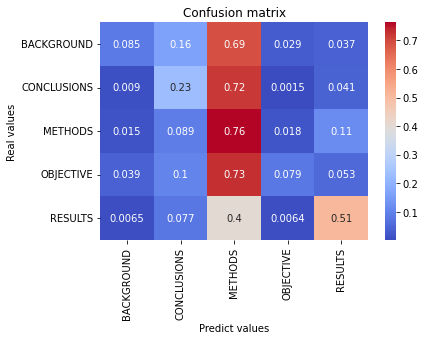

KeyboardInterrupt: 

In [22]:
l_pca = [3, 5, 10, 15, 30]

X_train, y_train, X_test, y_test = fun_features_engineering.get_final_data(df_train[['label', 'sentence']][:20000], df_test[['label', 'sentence']][:10000], model, to_do_pca=False)

for indice_pca in l_pca :
    pca = PCA(n_components=indice_pca)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    clf = RandomForestClassifier()
    clf.fit(X_train_pca, y_train)

    fm.display_metrics_and_confusion_matrix(clf, np.array(X_test_pca), y_test)